In [24]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [25]:
file = uproot.open("./features/JpsiTauNu_FWM.root")
# df_tau = file['t'].pandas.df()
df_tau = pd.DataFrame(np.array(file['t']['FWMs'].array()))

file = uproot.open("./features/JpsiMuNu_FWM.root")
df_mu = pd.DataFrame(np.array(file['t']['FWMs'].array()))

file = uproot.open("./features/RJpsiMisID_FWM.root")
df_misid = pd.DataFrame(np.array(file['t']['FWMs'].array()))

file = uproot.open("./features/RJpsiInclusive_FWM.root")
df_incl1 = pd.DataFrame(np.array(file['t']['FWMs'].array()))
file = uproot.open("./features/RJpsiInclusive_FWM_seed2.root")
df_incl2 = pd.DataFrame(np.array(file['t']['FWMs'].array()))
df_incl = pd.concat([df_incl1, df_incl2])

file = uproot.open("./features/RJpsiCombCascade_FWM.root")
df_comb = pd.DataFrame(np.array(file['t']['FWMs'].array()))

In [26]:
epsilon_pimu = 1/100

# No veto
modes_dt = {0: {'mode': './features/JpsiTauNu_10Noise_NoVeto.root', 'yields': 3.76e3}, 
            1: {'mode': './features/JpsiMuNu_10Noise_NoVeto.root', 'yields': 1.03e5},
            2: {'mode': './features/RJpsiInclusive_10Noise_NoVeto.root', 'yields': 3.90e3},
            3: {'mode': './features/RJpsiCombCascade_10Noise_NoVeto.root', 'yields': 7.98e4},
            4: {'mode': './features/RJpsiMisID_10Noise_NoVeto.root', 'yields': epsilon_pimu*1.10e8}
           }

def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        print('\rReading:', i)
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        
        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
#         print(len(idx))
        idx = idx[:20000]    # if too much data
#         idx = idx[:5000]    # if too much data
        num_lt.append(len(idx))    

        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(idx)
        print(df_i['weight'][0])
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

tr_te_split = 1
df_reco, _ = load_train_test(modes_dt, tr_te_split)
# make a copy
# df_train_o, df_test_o = df_train.copy(), df_test.copy()


Reading: 0
1.8458517427589594
Reading: 1
19.548301385462135
Reading: 2
44.827586206896555
Reading: 3
44.831460674157306
Reading: 4
55.0
train size: 29173 (100.00%); test size: 0 (0.00%)
data points per mode:  [2037, 5269, 87, 1780, 20000]


In [27]:
df_reco = df_reco[df_reco.target==3]
len(df_reco)

1780

In [28]:
# df_misid = df_misid.sample(10000)

In [29]:

df_comb['angle_sum'] = df_comb['angle1'] + df_comb['angle2']
df_comb['E_sum'] = df_comb['E1'] + df_comb['E2']


four_B = df_comb.nB == 4
two_B_two_c = (df_comb.nB == 2) & (df_comb.nC == 2)
# two_B = (df_comb.nB == 2) & (df_comb.nC == 0) 
two_B = (~ four_B) & (~ two_B_two_c)

df_4b = df_comb.loc[four_B]
df_2b2c = df_comb.loc[two_B_two_c]
df_2b = df_comb.loc[two_B]


In [30]:
np.array([len(df_2b), len(df_2b2c), len(df_4b)]) / (len(df_2b) + len(df_2b2c) + len(df_4b))

array([0.95404251, 0.03258046, 0.01337704])

In [31]:
df_comb.index = df_comb.iEvt

df_2b_cut = df_comb.loc[list(set(df_reco.iEvt).intersection(df_2b.iEvt))]
df_4b_cut = df_comb.loc[list(set(df_reco.iEvt).intersection(df_4b.iEvt))]
df_2b2c_cut = df_comb.loc[list(set(df_reco.iEvt).intersection(df_2b2c.iEvt))]

print(np.array([len(df_2b_cut), len(df_2b2c_cut), len(df_4b_cut)]) / (len(df_2b_cut) + len(df_2b2c_cut) + len(df_4b_cut)))

for y in np.array([len(df_2b_cut), len(df_2b2c_cut), len(df_4b_cut)]) / (len(df_2b_cut) + len(df_2b2c_cut) + len(df_4b_cut)):
    print("{:.2e}".format(y*7.98e4))

[0.50393258 0.32303371 0.17303371]
4.02e+04
2.58e+04
1.38e+04


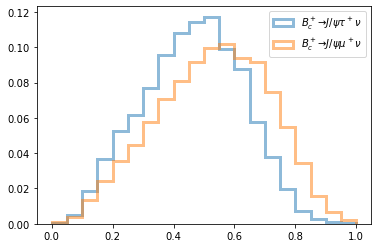

In [32]:
bins_=20
range_=[-0.,1.]

plt.hist(df_tau['H_EE2'], weights=[1/len(df_tau)]*len(df_tau), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c^+\to J/\psi \tau^+ \nu$');
plt.hist(df_mu['H_EE2'], weights=[1/len(df_mu)]*len(df_mu), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c^+\to J/\psi \mu^+ \nu$');
# plt.hist(df_misid['H_EE2'], weights=[1/len(df_misid)]*len(df_misid), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5);
# plt.hist(df_incl['H_EE2'], weights=[1/len(df_incl)]*len(df_incl), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5);

# plt.hist(df_2b['H_EE2'], weights=[1/len(df_2b)]*len(df_2b), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5);
# plt.hist(df_2b2c['H_EE2'], weights=[1/len(df_2b2c)]*len(df_2b2c), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5);
# plt.hist(df_4b['H_EE2'], weights=[1/len(df_4b)]*len(df_4b), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5);

plt.legend()

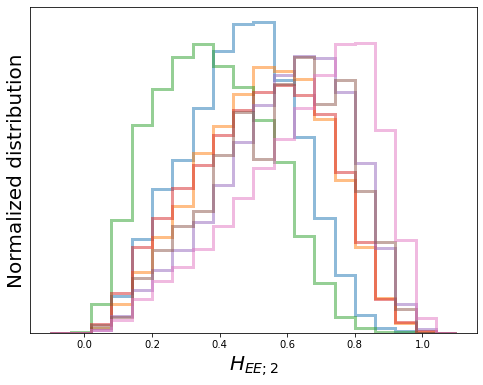

In [36]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

bins_=20
range_=[-0.1,1.1]

# bins_=30
# range_=[-0.5,1.]

df_tau_ = df_tau[(df_tau.H_EE2<=1)&(df_tau.H_EE2>=0)]
ax1.hist(df_tau_['H_EE2'], weights=[1/len(df_tau_)]*len(df_tau_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \tau \nu$', color='C0');

df_mu_ = df_mu[(df_mu.H_EE2<=1)&(df_mu.H_EE2>=0)]
ax1.hist(df_mu_['H_EE2'], weights=[1/len(df_mu_)]*len(df_mu_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \mu \nu$', color='C1');


df_4b_ = df_4b[(df_4b.H_EE2<=1)&(df_4b.H_EE2>=0)]
plt.hist(df_4b_['H_EE2'], weights=[1/len(df_4b_)]*len(df_4b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='4b', color='C2');

df_2b2c_ = df_2b2c[(df_2b2c.H_EE2<=1)&(df_2b2c.H_EE2>=0)]
plt.hist(df_2b2c_['H_EE2'], weights=[1/len(df_2b2c_)]*len(df_2b2c_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b2c', color='C3');

df_2b_ = df_2b[(df_2b.H_EE2<=1)&(df_2b.H_EE2>=0)]
plt.hist(df_2b_['H_EE2'], weights=[1/len(df_2b_)]*len(df_2b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b', color='C4');


df_incl_ = df_incl[(df_incl.H_EE2<=1)&(df_incl.H_EE2>=0)]
plt.hist(df_incl_['H_EE2'], weights=[1/len(df_incl_)]*len(df_incl_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='Incl.', color='C5');

df_misid_ = df_misid[(df_misid.H_EE2<=1)&(df_misid.H_EE2>=0)]
plt.hist(df_misid_['H_EE2'], weights=[1/len(df_misid_)]*len(df_misid_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='MisID', color='C6');



ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$H_{EE;2}$', fontsize=20)
ax1.set_yticks([])
# ax1.legend(loc=2, fontsize=20)

f.savefig('./figures/FWM_EE2')


In [37]:
HEE_col = ['H_EE0', 'H_EE1', 'H_EE2', 'H_EE3', 'H_EE4', 
           'H_EE5', 'H_EE6', 'H_EE7', 'H_EE8', 'H_EE9', 'H_EE10']

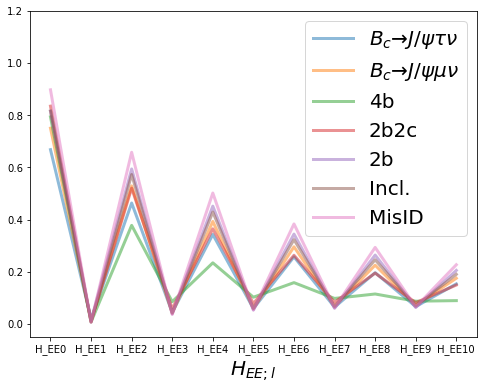

In [38]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)


df_tau[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label=r'$B_c\to J/\psi \tau \nu$', color='C0')
df_mu[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label=r'$B_c\to J/\psi \mu \nu$', color='C1')
df_4b[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label='4b', color='C2')
df_2b2c[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label='2b2c', color='C3')
df_2b[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label='2b', color='C4')
df_incl[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label='Incl.', color='C5')
df_misid[HEE_col].mean(axis=0).plot(lw=3, alpha=0.5, ax=ax1, label='MisID', color='C6')


ax1.set_ylim([-0.05, 1.2])
# ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$H_{EE;l}$', fontsize=20)
# ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)
ax1.set_xticks(np.arange(len(HEE_col)), HEE_col);

f.savefig('./figures/FWM_EEl')



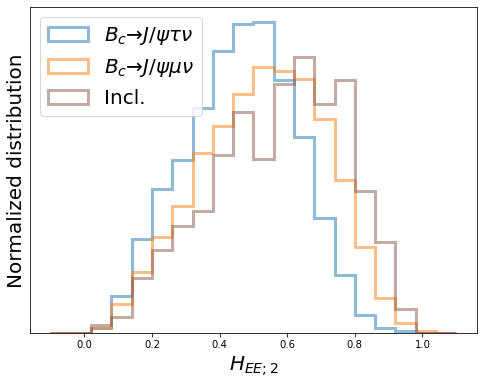

In [39]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

bins_=20
range_=[-0.1,1.1]

# bins_=30
# range_=[-0.5,1.]

df_tau_ = df_tau[(df_tau.H_EE2<=1)&(df_tau.H_EE2>=0)]
ax1.hist(df_tau_['H_EE2'], weights=[1/len(df_tau_)]*len(df_tau_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \tau \nu$', color='C0');

df_mu_ = df_mu[(df_mu.H_EE2<=1)&(df_mu.H_EE2>=0)]
ax1.hist(df_mu_['H_EE2'], weights=[1/len(df_mu_)]*len(df_mu_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \mu \nu$', color='C1');


# df_4b_ = df_4b[(df_4b.H_EE2<=1)&(df_4b.H_EE2>=0)]
# plt.hist(df_4b_['H_EE2'], weights=[1/len(df_4b_)]*len(df_4b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='4b', color='C2');

# df_2b2c_ = df_2b2c[(df_2b2c.H_EE2<=1)&(df_2b2c.H_EE2>=0)]
# plt.hist(df_2b2c_['H_EE2'], weights=[1/len(df_2b2c_)]*len(df_2b2c_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b2c', color='C3');

# df_2b_ = df_2b[(df_2b.H_EE2<=1)&(df_2b.H_EE2>=0)]
# plt.hist(df_2b_['H_EE2'], weights=[1/len(df_2b_)]*len(df_2b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b', color='C4');


df_incl_ = df_incl[(df_incl.H_EE2<=1)&(df_incl.H_EE2>=0)]
plt.hist(df_incl_['H_EE2'], weights=[1/len(df_incl_)]*len(df_incl_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='Incl.', color='C5');

# df_misid_ = df_misid[(df_misid.H_EE2<=1)&(df_misid.H_EE2>=0)]
# plt.hist(df_misid_['H_EE2'], weights=[1/len(df_misid_)]*len(df_misid_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='MisID', color='C6');



ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$H_{EE;2}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=2, fontsize=20)

f.savefig('./figures/FWM_EE2_Bc_incl')


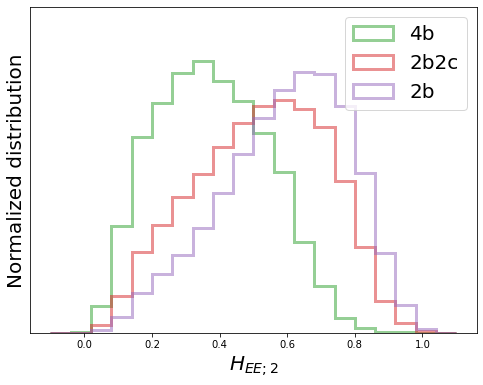

In [41]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

bins_=20
range_=[-0.1,1.1]

ax1.margins(y=0.2)
# ax1.margins(y=0.4)

# bins_=30
# range_=[-0.5,1.]

# df_tau_ = df_tau[(df_tau.H_EE2<=1)&(df_tau.H_EE2>=0)]
# ax1.hist(df_tau_['H_EE2'], weights=[1/len(df_tau_)]*len(df_tau_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \tau \nu$', color='C0');

# df_mu_ = df_mu[(df_mu.H_EE2<=1)&(df_mu.H_EE2>=0)]
# ax1.hist(df_mu_['H_EE2'], weights=[1/len(df_mu_)]*len(df_mu_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \mu \nu$', color='C1');


df_4b_ = df_4b[(df_4b.H_EE2<=1)&(df_4b.H_EE2>=0)]
plt.hist(df_4b_['H_EE2'], weights=[1/len(df_4b_)]*len(df_4b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='4b', color='C2');

df_2b2c_ = df_2b2c[(df_2b2c.H_EE2<=1)&(df_2b2c.H_EE2>=0)]
plt.hist(df_2b2c_['H_EE2'], weights=[1/len(df_2b2c_)]*len(df_2b2c_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b2c', color='C3');

df_2b_ = df_2b[(df_2b.H_EE2<=1)&(df_2b.H_EE2>=0)]
plt.hist(df_2b_['H_EE2'], weights=[1/len(df_2b_)]*len(df_2b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b', color='C4');


# df_incl_ = df_incl[(df_incl.H_EE2<=1)&(df_incl.H_EE2>=0)]
# plt.hist(df_incl_['H_EE2'], weights=[1/len(df_incl_)]*len(df_incl_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='Incl.', color='C5');

# df_misid_ = df_misid[(df_misid.H_EE2<=1)&(df_misid.H_EE2>=0)]
# plt.hist(df_misid_['H_EE2'], weights=[1/len(df_misid_)]*len(df_misid_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='MisID', color='C6');



ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel(r'$H_{EE;2}$', fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_EE2_bs')


In [352]:
len(df_2b), len(df_4b), len(df_2b2c)

(988202, 13856, 33747)

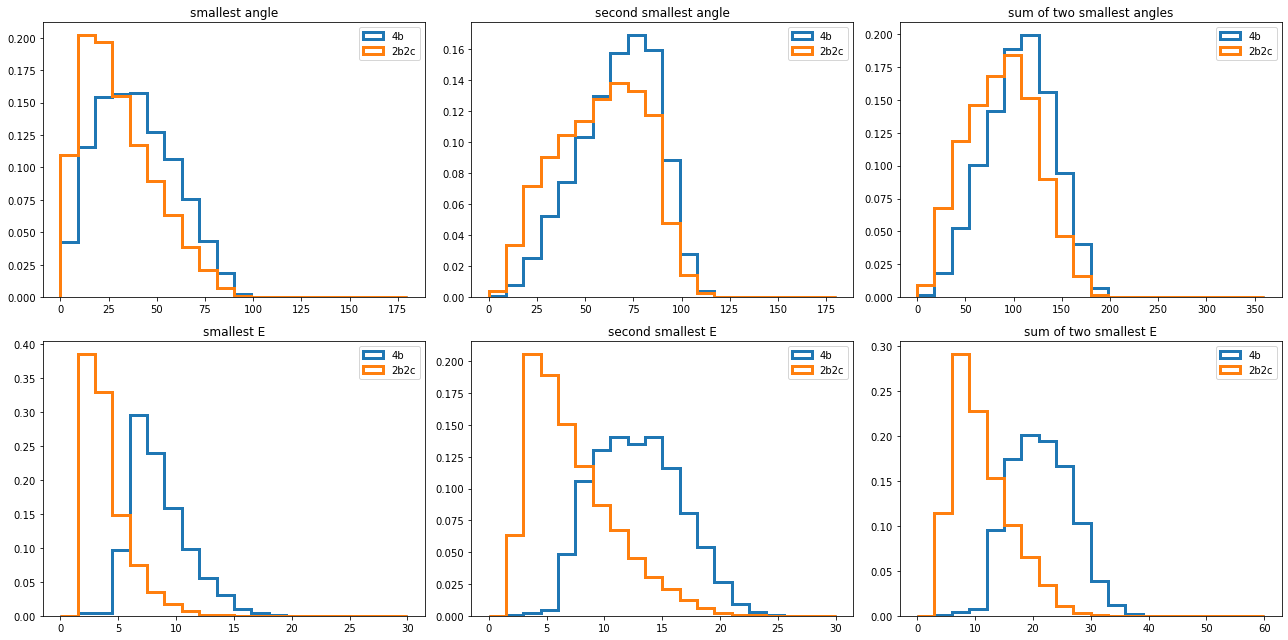

In [353]:
f = plt.figure(figsize=(18,9))
ax1 = plt.subplot(231)
ax1.hist(df_4b['angle1'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180], histtype='step', lw=3, label='4b');
ax1.hist(df_2b2c['angle1'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180], histtype='step', lw=3, label='2b2c');
ax1.set_title("smallest angle")
plt.legend()

ax2 = plt.subplot(232)
ax2.hist(df_4b['angle2'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180], histtype='step', lw=3, label='4b');
ax2.hist(df_2b2c['angle2'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180], histtype='step', lw=3, label='2b2c');
ax2.set_title("second smallest angle")
plt.legend()

ax3 = plt.subplot(233)
ax3.hist(df_4b['angle_sum'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180*2], histtype='step', lw=3, label='4b');
ax3.hist(df_2b2c['angle_sum'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180*2], histtype='step', lw=3, label='2b2c');
ax3.set_title("sum of two smallest angles")
plt.legend()

ax4 = plt.subplot(234)
ax4.hist(df_4b['E1'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30], histtype='step', lw=3, label='4b');
ax4.hist(df_2b2c['E1'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30], histtype='step', lw=3, label='2b2c');
ax4.set_title("smallest E")
plt.legend()

ax5 = plt.subplot(235)
ax5.hist(df_4b['E2'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30], histtype='step', lw=3, label='4b');
ax5.hist(df_2b2c['E2'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30], histtype='step', lw=3, label='2b2c');
ax5.set_title("second smallest E")
plt.legend()

ax6 = plt.subplot(236)
ax6.hist(df_4b['E_sum'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30*2], histtype='step', lw=3, label='4b');
ax6.hist(df_2b2c['E_sum'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30*2], histtype='step', lw=3, label='2b2c');
ax6.set_title("sum of two smallest E")
plt.legend()

plt.tight_layout()
# f.savefig('./angles_energies', bbox_inches='tight')

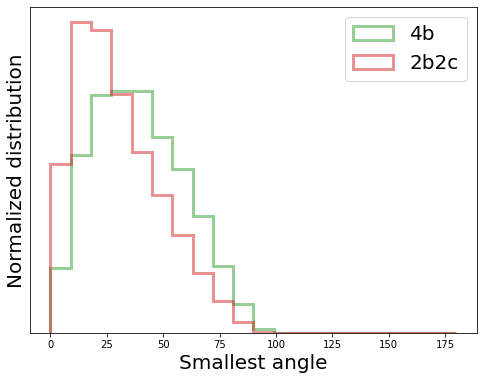

In [42]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['angle1'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['angle1'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');

plt.legend()


ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Smallest angle", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SmallestAngle')


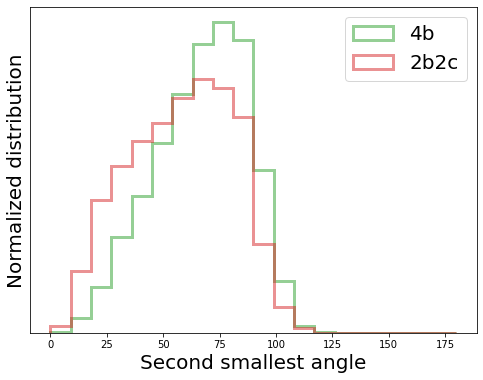

In [43]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['angle2'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['angle2'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');
# ax1.set_title("")


ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Second smallest angle", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SecondSmallestAngle')


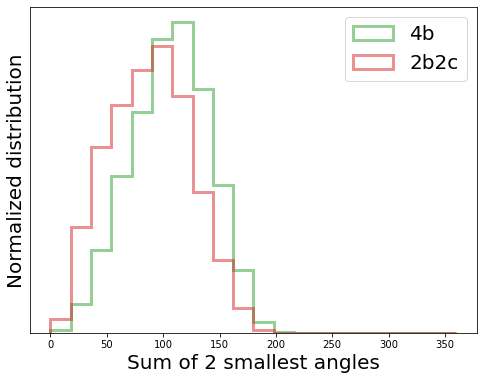

In [44]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['angle_sum'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,180*2], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['angle_sum'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,180*2], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');


ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Sum of 2 smallest angles", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SumAngle')


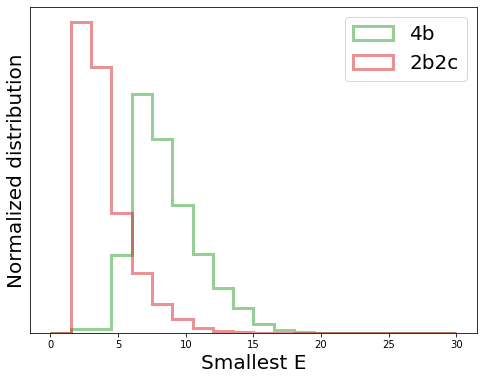

In [45]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['E1'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['E1'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Smallest E", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SmallestE')


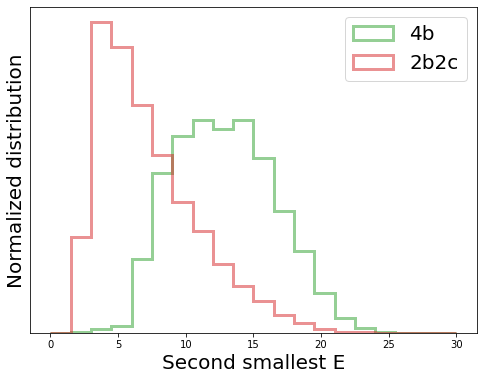

In [46]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['E2'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['E2'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Second smallest E", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SecondSmallestE')


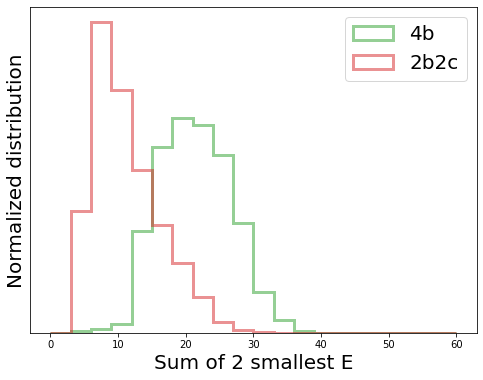

In [47]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

ax1.hist(df_4b['E_sum'], weights=[1/len(df_4b)]*len(df_4b), bins=20, range=[0,30*2], histtype='step', lw=3, label='4b', alpha=0.5, color='C2');
ax1.hist(df_2b2c['E_sum'], weights=[1/len(df_2b2c)]*len(df_2b2c), bins=20, range=[0,30*2], histtype='step', lw=3, label='2b2c', alpha=0.5, color='C3');

ax1.set_ylabel('Normalized distribution', fontsize=20)
ax1.set_xlabel("Sum of 2 smallest E", fontsize=20)
ax1.set_yticks([])
ax1.legend(loc=1, fontsize=20)

f.savefig('./figures/FWM_SumE')


In [360]:
len(df_2b)

988202

In [361]:
len(df_2b2c)

33747

In [362]:
len(df_4b)

13856

[]

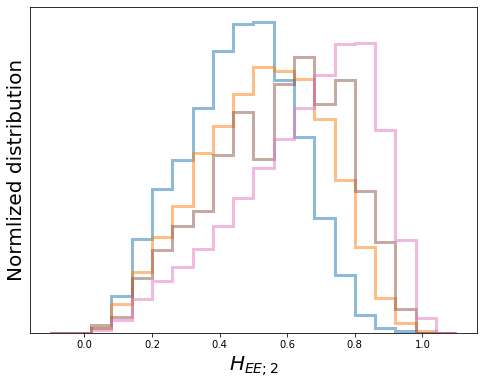

In [15]:

f = plt.figure(figsize=(8,6))
ax1 = plt.subplot(111)

bins_=20
range_=[-0.1,1.1]

# bins_=30
# range_=[-0.5,1.]

df_tau_ = df_tau[(df_tau.H_EE2<=1)&(df_tau.H_EE2>=0)]
ax1.hist(df_tau_['H_EE2'], weights=[1/len(df_tau_)]*len(df_tau_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \tau \nu$', color='C0');

df_mu_ = df_mu[(df_mu.H_EE2<=1)&(df_mu.H_EE2>=0)]
ax1.hist(df_mu_['H_EE2'], weights=[1/len(df_mu_)]*len(df_mu_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label=r'$B_c\to J/\psi \mu \nu$', color='C1');


# df_4b_ = df_4b[(df_4b.H_EE2<=1)&(df_4b.H_EE2>=0)]
# plt.hist(df_4b_['H_EE2'], weights=[1/len(df_4b_)]*len(df_4b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='4b', color='C2');

# df_2b2c_ = df_2b2c[(df_2b2c.H_EE2<=1)&(df_2b2c.H_EE2>=0)]
# plt.hist(df_2b2c_['H_EE2'], weights=[1/len(df_2b2c_)]*len(df_2b2c_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b2c', color='C3');

# df_2b_ = df_2b[(df_2b.H_EE2<=1)&(df_2b.H_EE2>=0)]
# plt.hist(df_2b_['H_EE2'], weights=[1/len(df_2b_)]*len(df_2b_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='2b', color='C4');


df_incl_ = df_incl[(df_incl.H_EE2<=1)&(df_incl.H_EE2>=0)]
plt.hist(df_incl_['H_EE2'], weights=[1/len(df_incl_)]*len(df_incl_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='Incl.', color='C5');

df_misid_ = df_misid[(df_misid.H_EE2<=1)&(df_misid.H_EE2>=0)]
plt.hist(df_misid_['H_EE2'], weights=[1/len(df_misid_)]*len(df_misid_), range=range_, bins=bins_, histtype='step', lw=3, alpha=0.5, label='MisID', color='C6');



ax1.set_ylabel('Normlized distribution', fontsize=20)
ax1.set_xlabel(r'$H_{EE;2}$', fontsize=20)
ax1.set_yticks([])
# ax1.legend(loc=2, fontsize=20)

# f.savefig('./figures/FWM_EE2')
